# CONTOUR MASKING

using [hull of] biggest contour

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

## WORK IN PROGRESS
# CLOSES MAX CONTOUR TO USE IT AS A MASK
def closeCnt(image2close):
    kernel = np.ones((25,25),np.uint8)#cv.getStructuringElement(cv.MORPH_RECT,(10,10)) 
    image2close=cv.morphologyEx(image2close,cv.MORPH_CLOSE,kernel)
    image2close=cv.morphologyEx(image2close,cv.MORPH_RECT,kernel)
    kernel =cv.getStructuringElement(cv.MORPH_RECT,(10,10))
    image2close=cv.dilate(image2close,kernel,iterations=2)
    kernel = np.ones((15,15),np.uint8)
    image2close=cv.morphologyEx(image2close,cv.MORPH_OPEN,kernel)
    return image2close

# RETURN ROI RECTANGLE AND ROI CENTER AND COSMETICHS
def roiHud(image2hud,cnt2hud,hull2hud,nocount=0,nohull=0,norect=0,nocentr=0):
    # draw max contour
    if not nocount:cv.drawContours(image2hud, cnt2hud, -1,(25,205,255), 10)
    
    # draw convex hull
    if not nohull:cv.drawContours(image2hud, [hull2hud], -1, (255, 255, 0), 5)

    # rotated rect 
#     rect = cv.minAreaRect(cnt2hud)
#     box = np.int0(cv.boxPoints(rect))
#     cv.drawContours(image2hud, [box], 0, (0,0,255), 8)

    # bounding rect and center
    xR,yR,wR,hR = cv.boundingRect(cnt2hud)
    if not norect:cv.rectangle(image2hud, (xR,yR), (xR+wR,yR+hR), (255,0,255), 5)

    # rectangle center
    xcR,ycR=xR+wR//2, yR+hR//2
    if not nocentr:cv.circle(image2hud, (xcR,ycR), 15, (0,255,0), 18)
    
    return image2hud, (xcR, ycR),(wR,hR)
print('done')

done


In [2]:
# image to find contour and roi
##result of previous code coventiently modified as if robot not present
foreground=cv.imread('../../images/panel/panel_real.jpg')
h,w,_=foreground.shape
##center for alignment pourposes, in foreground coord
##use not extended images, they'll be casted in extended image
co=(w//2,h//2)

# image to print, POV camera video stream simulation
sourceimg=cv.imread('../../images/marsyard/task_newnew.jpg')
##sourceimg could be a frame extracted from the video stream
sourcecopy=sourceimg.copy()

#foreground=bgForeImprov(foreground)

# foreground grayscaling and binarization
imgcnts = cv.cvtColor(foreground, cv.COLOR_BGR2GRAY)
#imgtrack = cv.threshold(bpMask,10,255,0)#, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
imgcnts[imgcnts<10]=0
imgcnts[imgcnts>=10]=255

#imgcnts=cv.Canny(imgcnts,120,60)
## canny's edges do not appear to improve the contour closing results

# close max contour
# imgcnts=closeCnt(imgcnts)

# contours
cnts = cv.findContours(imgcnts, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
##contours closing possible also after, test didn't work

# max contour, hull and hullmask
maxcnt=max(cnts, key=len)
#_maxcnt=max(cnts, key=lambda x: cv.contourArea(x)) ##alternatively
hullmax=cv.convexHull(maxcnt)
#hullMask=cv.cvtColor(cv.fillConvexPoly(np.zeros(foreground.shape,np.uint8),hullmax,255),cv.COLOR_BGR2GRAY)
hullMask=cv.fillConvexPoly(np.zeros((h,w),np.uint8),hullmax,255)

# FOREGROUND

# masked foreground image
foreground=cv.bitwise_and(foreground,foreground,mask=hullMask)

# image with roi highlight and center
forehud,rco,(wr,hr)=roiHud(sourceimg,maxcnt,hullmax)
##paneltask_real: rco=(370, 621), hr=1013, wr=705
##     paneltask: rco=(388, 609), hr=995 , wr=671

# ROI center in foreground coordinates
rcox,rcoy=rco
# upperleftmost point of roi
rx,ry=rcox-wr//2,rcoy-hr//2
# roi dimensions
# wr, hr
##dimensions to construct the fake background

# toggles clean input without hud
freshInput=0
if freshInput:
    forehud=sourcecopy
    #cv.circle(forehud, (rco), 15, (0,255,0), 14)
    
# displaying
if 0:  
    plt.figure(figsize=(20,10))
    plt.imshow(cv.cvtColor(forehud,cv.COLOR_BGR2RGB))
    plt.title('roi highlighting') if not(freshInput) else plt.title('clean input')
    plt.show()
    plt.figure(figsize=(20,10))
    plt.imshow(cv.cvtColor(foreground,cv.COLOR_BGR2RGB))
    plt.title('masked image as feeded to algorithm')
    plt.show()

print('done')



done


# MOTION  SIMULATION

can toggle between video recording or frame display;



In [3]:

# MOTION PARAMETERS
# robot traverse action (simulation by moving the image, macrostep)
motx=motx0=70
moty=moty0=0
# traverse action divided in steps €[1,motx] (for graphical reasons, microstep) 
stepx=stepx0=13
stepx=motx0 if stepx0>motx0 else (1 if stepx0<1 else stepx0)
##effective motion is of motx entity, which is performed in stepx entity steps

# motion termination criterion, by roi and POV center distance
epsx=0
if epsx<0: epsz=0
# motion action dimming test array 
motestx=[]
    
# BACKGROUND 
##result of masking the camera POV, big enough to center each possible roi
## height depending on max nearess robot will approach the panel
H,W=2*h+moty0,w*2+motx0
##leave h to have video size of foreground image, but roi center won't be centered
background=np.zeros((H,W,3),np.uint8)
# center in POV coord.
CO=(W//2+1+motx0//2,H//2+moty0//2)
##incremented of 1 for graphical purposes



# IMAGE CENTERS GEOMETRY
# rcC= rcO-CO=rco+oO-CO
## rcC: POV center-ROI center; to minimize
## rcO: roi center in POV coord.
## CO: background center in POV coord.
## oO: foreground origin in POV coord.

# starting position of foreground in POV camera

oO=(oOx,oOy)=(oOx0,oOy0)=(0,CO[1]-rcoy)
##oO0y s.t. aligns vertically POV and ROI center, supposing similar vertical aligning system as well
##oO0x arbitrary
#_add random position with test on possible casting foreground image in background shape

##addiotional geometries
# rcO=roO+rcro
## roO: roi origin in POV coord.
## rcro: roi center in ROI coord.== (wr/2,hr/2); const
# roO=roo+oO
## roo: roi origin in FOREGROUND coord.; const
    


    
# FRAME EXTENSION
# extends the output height of this many pixel wrt roih
exthr=100
if exthr<0: exthr= 0
# ROi in extended coord
roicx,roicy=rcox,rcoy+exthr//2
roih,roiw=hr,wr
roix,roiy=roicx-roiw//2,exthr//2

# extended hull mask
extHullMask=np.zeros((H,W),np.uint8)
extHullMask[oOy0:oOy0+h,oOx0:oOx0+w]=hullMask
extHullMask=extHullMask[CO[1]-hr//2-exthr//2:CO[1]+hr//2+exthr//2,:]

extforeground=np.zeros((H,W,3),np.uint8)
extforeground[oOy0:oOy0+h,oOx0:oOx0+w]=cv.imread('../../images/marsyard/task_newnew.jpg')
extforeground=extforeground[CO[1]-hr//2-exthr//2:CO[1]+hr//2+exthr//2,:]

# apply extended hullMask
if 0:
    extforeground=cv.bitwise_and(extforeground,extforeground,mask=extHullMask)
# write result
if 0:
    cv.imwrite('../../images/panel/extended/',extforeground)

#############
print('done')

done


motion starting
rcO [370, 1335] rcC [1701, 0] CO  (2071, 1335) oO  (0, 714)


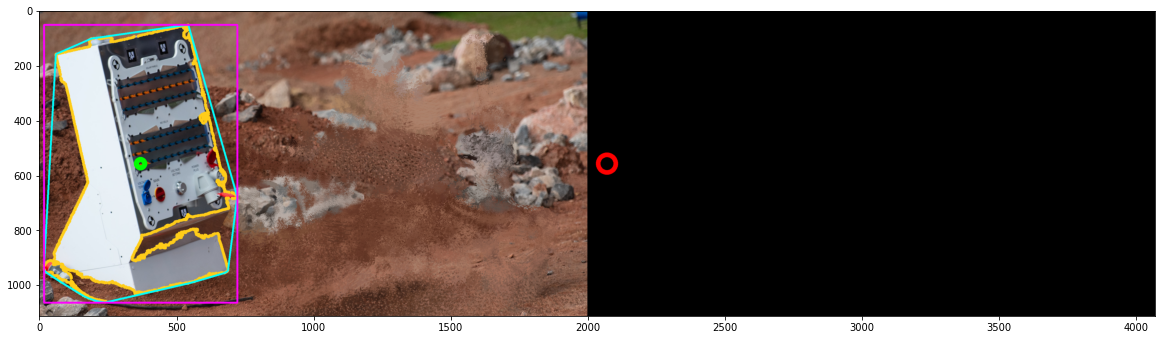

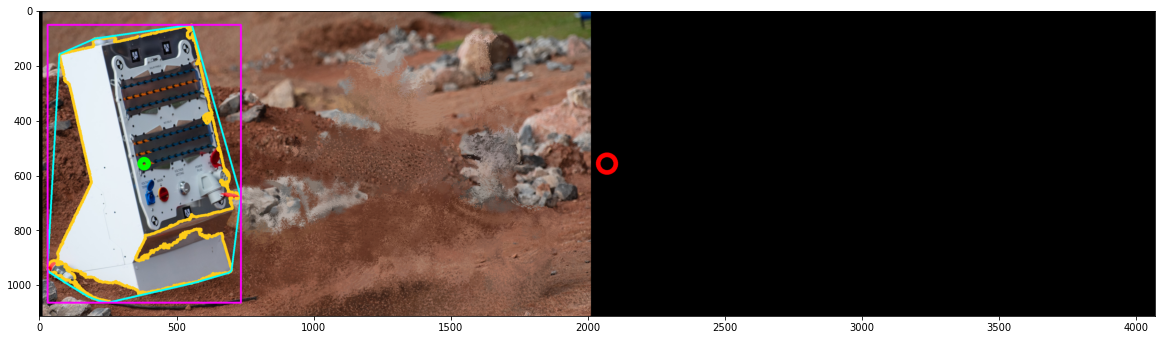

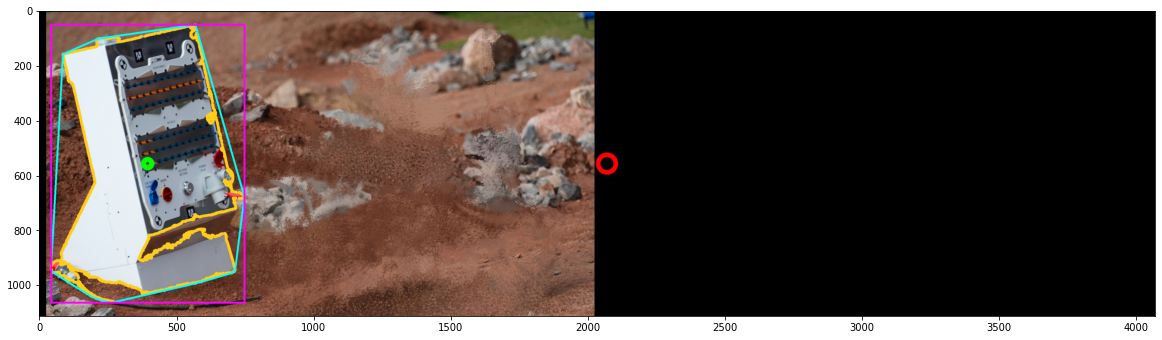

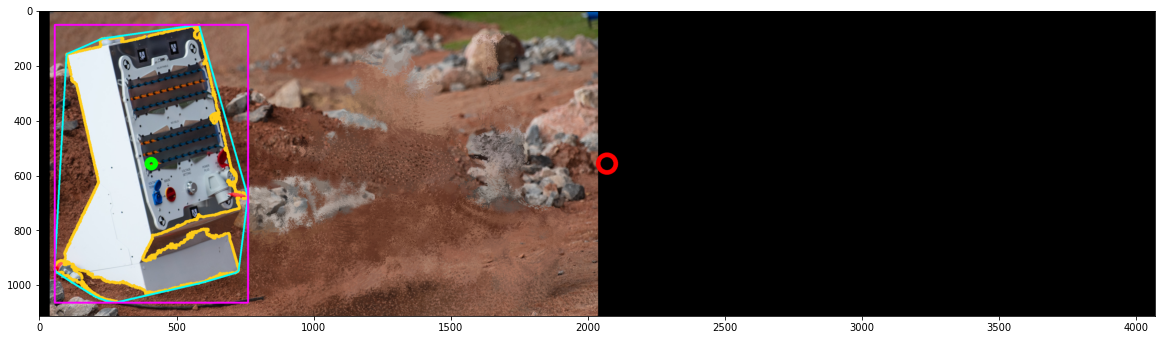

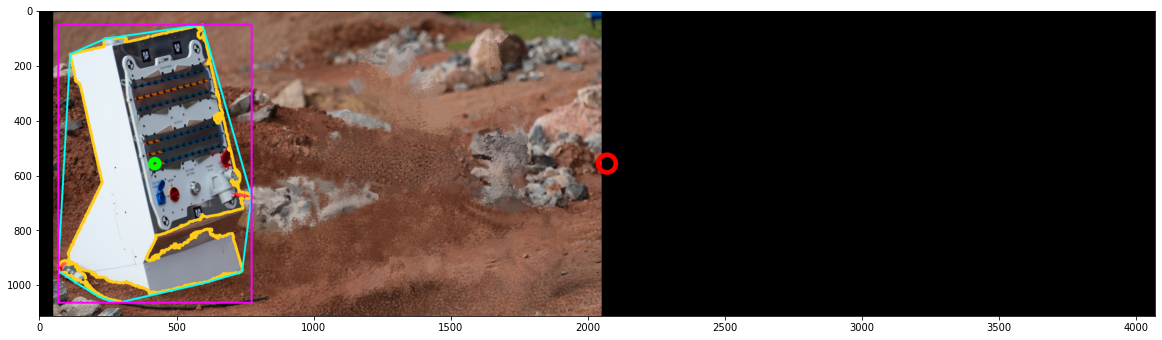

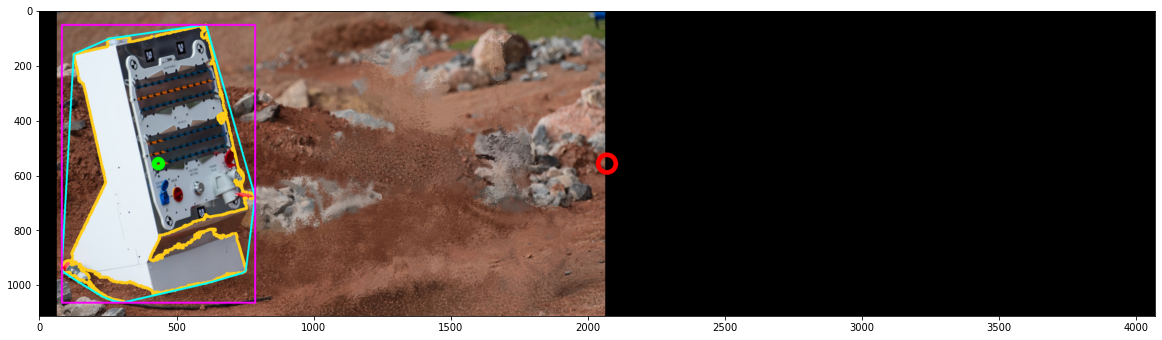

### moving ###
rcO [448, 1335] rcC [1623, 0] CO  (2071, 1335) oO  (78, 714)


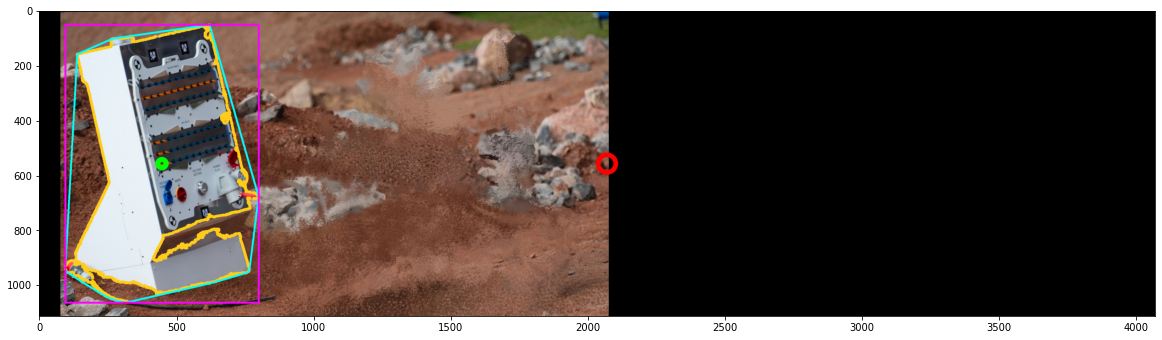

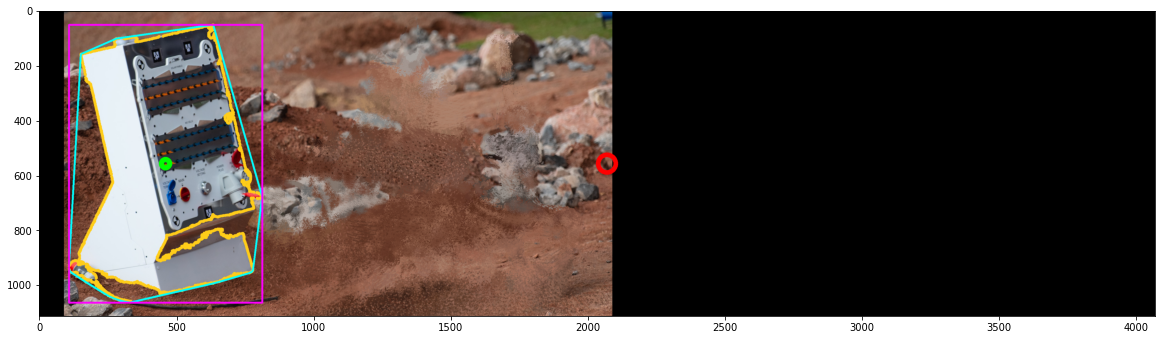

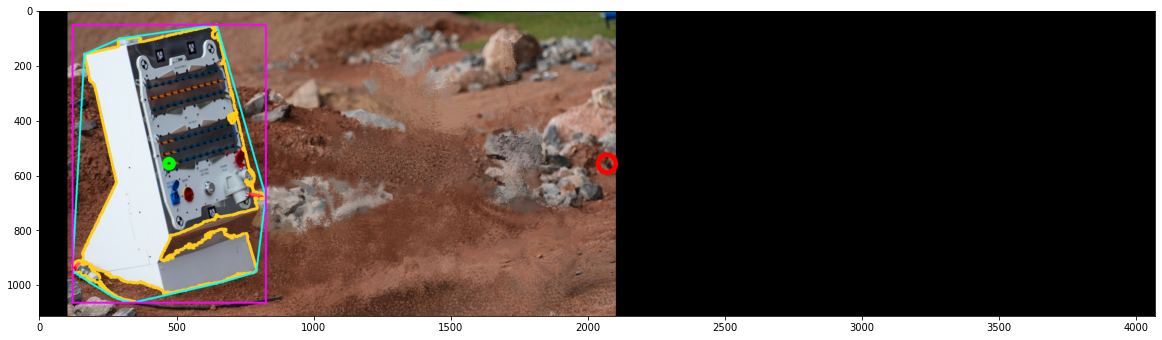

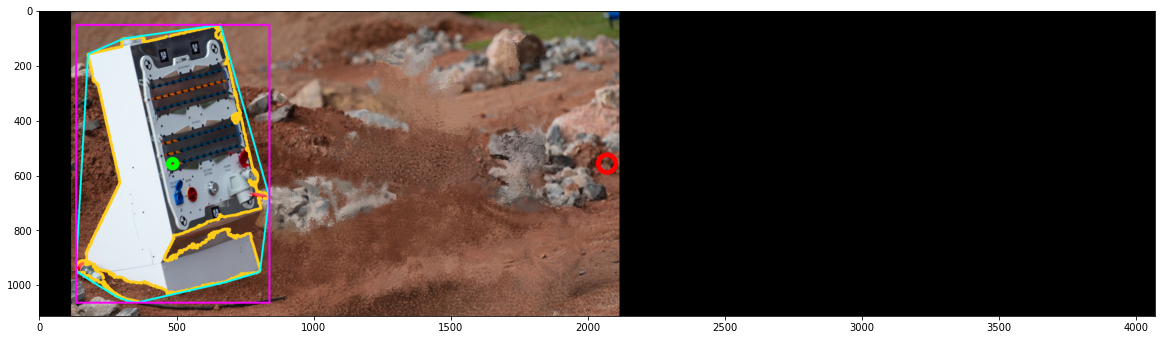

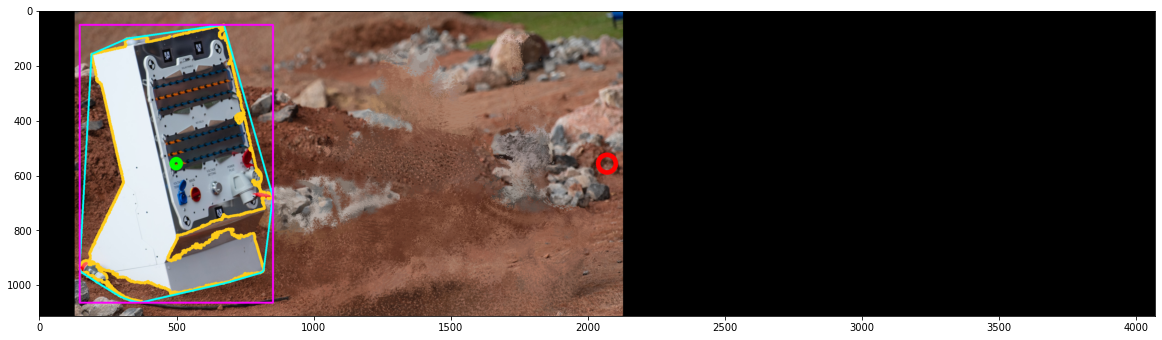

KeyboardInterrupt: 

In [17]:
# toggle printing of information
togglePrint=1

# toggles video recording
vidRecNoPrint=0

# toggles image plotting 
plotNoRec=0 if vidRecNoPrint else 1
##change last one only

# toggles storing of first output image
click=0
if click:clickimage=[]

# OUTPUT AND VIDEO RECORDING   
if vidRecNoPrint:
#     empty video array and frame dimensions
    video_array = []
    videoH,videoW=hr+exthr,W
    video_size =(videoW,videoH)
    COneo=video_size//2
    #_adapt width to starting initial conditoin for foreground
    
if togglePrint:print('video recording started') if vidRecNoPrint else print('motion starting')
    
# MOTION
while(1):##actually a do-while
    
    # geometric referencing
    rcO=[sum(jj) for jj in zip(rco, oO)]##increasing
    rcC=rcCx,rcCy=[sum(jj) for jj in zip(CO, np.negative(rcO))]
    ##rcCx>0 if roi center on POV center's left
    if togglePrint:print('rcO',rcO,'rcC',rcC,'CO ',CO,'oO ',oO)
    
    # ACTUATION CONTROL
    # test array accumulation
    motestx.append(rcCx)
    # accumulation stop criterion
    if len(motestx)>2:
        # remove oldest stored position
        motestx.pop(0)
        if motestx[0]*motestx[1]<0:
            # traverse action dimming
            motx=motx//2
            if stepx>1: stepx=stepx//2
            if togglePrint:print('oscilaltions along x!horizontal speed reduction')
            #_may modify in motion proportional to distance, ie K control
       
    # MOTION ACTUATION
    # motion direction detection
    actualx=stepx if rcCx>0 else -stepx   
    # motion steps performance
    for count in range(0,motx,stepx):
        # creation of a new empty background
        backprint=background.copy()
        # foreground insertion
        backprint[oOy:oOy+h,oOx:oOx+w]=forehud
        # POV center marker
        cv.circle(backprint,CO,32,(0,0,255),16)
        
        # output simmetric wrt roi center
        motOutput=backprint[CO[1]-hr//2-exthr//2:CO[1]+hr//2+exthr//2,:]
        if click: clickimage=motOutput;click=0
        # output redirection
        if vidRecNoPrint:
            video_print=motOutput
            video_array.append(video_print)
        elif plotNoRec:
            plt.figure(figsize=(20,10))
            plt.imshow(cv.cvtColor(motOutput,cv.COLOR_BGR2RGB))
#             plt.imshow(cv.cvtColor(motOutput[:,min(rcO[0]-wr//2,CO[0]-wr//2):\
#                    max(rcO[0]+wr//2,CO[0]+wr//2)],cv.COLOR_BGR2RGB))
            plt.show()
     
        # motion of foreground position toward center
        oO=oOx,oOy=oOx+actualx,oOy
        
        
    # MOTION TERMINATION        
    # motion termination test on distance roi center-POV center
    if abs(rcCx)<=epsx:
        # reset traverse actions for future requests
        motx=motx0
        stepx=stepx0
        if not vidRecNoPrint and togglePrint:print('terminating motion along x...')
        # interrupts action
        break
        
    if togglePrint: print('### moving ###')
        
if togglePrint: print('__motion terminated__') 

# video memorization
if vidRecNoPrint:
    # video object
    video_out = cv.VideoWriter('../../images/video/video_task.avi',cv.VideoWriter_fourcc(*'DIVX'), 15, video_size) 
    # replicates each frame this number of times
    clonedFrames=0
    if clonedFrames>0:
        # frames cloning
        video_array2=[ii for ii in video_array for jj in range(clonedFrames+1)]
        # frames array writen in video object
        for ii in video_array2: video_out.write(ii)
    else:
        for ii in video_array: video_out.write(ii)
            
    video_out.release()

    print('video recording terminated')
print('done')

#### traversing function

omitted since can't work properly by printing motions steps

In [ ]:
# # def moTraverse(xmotion,xstep,xdist,framedist,imgbackground,imgforeground,roih)
# #     MOTION PERFORMANCE
    
# #     motion direction detection
#     actualx=xstep if xdist>0 else -xstep  
# #     motion steps performance
#     for count in range(0,xmotion,xstep):
#         if xstep!=xmotion:print('step ',count,'/',xmotion) 
# #         motion of foreground position toward center
#         framedist=framedistx,framedisty=framedist[0]+actualx,framedist[1]
# #         creation of a new empty background
#         imgbackprint=imgbackground.copy()
# #         foreground insertion
#         foregroundh,foregroundw,_=imgforeground.shape
#         imgbackprint[framedisty:framedisty+foregroundh,\
#                      framedistx:framedistx+foregroundw]=imgforeground
# #         POV center marker
#         ,_=list(reversed())
#         _,aax,aay=_,*backgroundCenter=np.floor_divide(list(reversed(imgbackground.shape)),2)
#         cv.circle(imgbackprint,backgroundCenter,40,(0,0,255),20)
        
#         outputImage=backprint[backgroundCenter[1]-(roih//2):backgroundCenter[1]+roih//2,:]
#     return framedist,outputImage
    
# oO,outputimage=(oOx,oOy),motOutput=moTraverse(motx,stepx,rcCx,oO,)
# #         output redirection
# if toggleVideoRec:
#     video_print=motOutput
#     video_array.append(video_print)
# else:
# #     print('rcCx ',rcCx,',motestx ',motestx,', stepx ',stepx)#debug
#     plt.imshow(cv.cvtColor(motOutput,cv.COLOR_BGR2RGB))
# #     plt.imshow(cv.cvtColor(motOutput[:,min(rcO[0]-wr//2-5,CO[0]-wr//2-5):\
# #            max(rcO[0]+wr//2+5,CO[0]+wr//2+5)],cv.COLOR_BGR2RGB))
#     plt.show()    


# FOREGROUND TRACKING

## by histogram matching & mean/camshift

1. get roi center and shape by relative function
    1. here is simulated and adapted in the new extended coord by means of crafted video
    2. also here bigger ad smaller roi available
2. roi histogram
3. backprojection on new frame
4. shift algoritm to estimate window movement

#### issues:

tracking windows appears to be shifted (especially down) wrt initial one (testd as correct after a testRoi); this could be relative to histogram itself

#### improvements:

to avoid considering the black pixels, present in the area where the histogram is analyzed, add a mask to the calcHist, considering that black[hsv] s.t. value==0

https://stackoverflow.com/questions/62875780/how-to-calculate-histogram-on-opencv-without-taking-into-consideration-all-black

https://stackoverflow.com/questions/36689915/opencv-ignoring-pixels-when-generating-a-hue-histogram

In [5]:

# video loading
videosrc='../../images/video/task_ext.avi'
trackcap = cv.VideoCapture(videosrc)
# setup initial location of window
if trackcap.isOpened():
    capret, capframe = trackcap.read()
else: trackcap.release()

#-# OPTIMAL result: only H channel and smaller window, roiSmall

# roi upper left vertex and size
roix,roiy=rcox-wr//2,exthr//2
roih,roiw=hr,wr
# tracking window
roiWin=(roix,roiy,roiw,roih)

# smaller roi
sroix,sroiy=roix+roiw//4,roiy+roih//4
sroih,sroiw=roih//2,roiw//2
sroiWin=(sroix,sroiy,sroiw,sroih)

# toggles drawing of rectangles to dispay correct area of roi
testRoi=0
if testRoi:
    cv.rectangle(capframe,(sroix,sroiy),(sroix+sroiw,sroiy+sroih),(255,255,0),3)
    cv.rectangle(capframe,(roix,roiy),(roix+roiw,roiy+roih),(255,255,0),3)
    plt.figure(figsize=(20,10));plt.imshow(capframe);plt.show()
    
# for fast switching between them
winLib=(roiWin,sroiWin)
win_select=winLib[0]

# ROI for tracking and histograms
# as extracted from the video
roiVidh=cv.cvtColor(capframe[roiy:roiy+roih,roix:roix+roiw],cv.COLOR_BGR2HSV)
roiSmallh=cv.cvtColor(capframe[sroiy:sroiy+sroih,sroix:sroix+sroiw],cv.COLOR_BGR2HSV)
# as taken from masking result, in foreground coord
roiMaskedh=cv.cvtColor(foreground[rcoy-hr//2:rcoy+hr//2,rcox-wr//2:rcox+wr//2].copy(),cv.COLOR_BGR2HSV)

roiLib=(roiVidh,roiSmallh,roiMaskedh)
roi_select=roiLib[1]

# HISTOGRAM
# toggles use of only Hue channel    
HchanOnly=1
h_bins = 180
s_bins = 256
histSize = [h_bins] if HchanOnly else [h_bins, s_bins]
h_ranges = [0, 180]
ranges = h_ranges
if not HchanOnly:s_ranges = [0, 256]; ranges+=s_ranges
channels = [0] if HchanOnly else [0, 1]

histroi=cv.calcHist([roi_select],channels,None,histSize,ranges)
cv.normalize(histroi,histroi,0,255,cv.NORM_MINMAX)
#_add mask for black pixels s.t roihsv[roihsv.val>0]

##histMasked=cv.calcHist([roiMaskedh],[0,1],None,[180,256],[0,180,0,256]) 
##equivalent to:
#histroieq1=cv.calcHist([cv.cvtColor(extforeground,cv.COLOR_BGR2HSV)],[0,1],extHullMask,[179,255],[1,180,1,256])
#histroieq2=cv.calcHist([cv.cvtColor(foreground,cv.COLOR_BGR2HSV)],[0,1],hullMask,[179,255],[1,180,1,256])


# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

# toggles use of meanshift or camshift (if 0)
doMeanShift=1
while(1):
    capret, capframe = trackcap.read()
    
    if capret == True:
        caph = cv.cvtColor(capframe, cv.COLOR_BGR2HSV)
        
        capdest = cv.calcBackProject([caph],channels,histroi,ranges,1)
        
        if doMeanShift:
            # apply meanshift to get the new location
            capret, win_select = cv.meanShift(capdest, win_select, term_crit)
            # Draw it on image
            xtr,ytr,wtr,htr = win_select
            trackres = cv.rectangle(capframe, (xtr,ytr),(xtr+wtr,ytr+htr), (0,255,0),10)
        else:
            # apply camshift to get the new location
            capret, win_select = cv.CamShift(dcapest, win_select, term_crit)
            # Draw it on image
            cappts = np.int0(cv.boxPoints(capret))
            trackres = cv.polylines(capframe,[cappts],True, (0,255,0),10)
        cv.imshow('tracking result',trackres)
        k = cv.waitKey(30) & 0xff
        if k == 27:
            break
    else:
        break
cv.destroyAllWindows()
   
print('done')

KeyboardInterrupt: 

## tracking by feature maching

this can be intended as a less ready-to-go solution for the tracking problem

once roi is found by means of contours left after background remotion, 
1. take a region contained in it which certeaintly present some peculiar feature of the panel, e.g a rectangle around roi center with same proportion as roi's rectangle
2. extract features inside that area
3. extract features from the new video frame
4. match features of new frame with roi ones
5. reconstruct the area that contains that features and define a new roi center

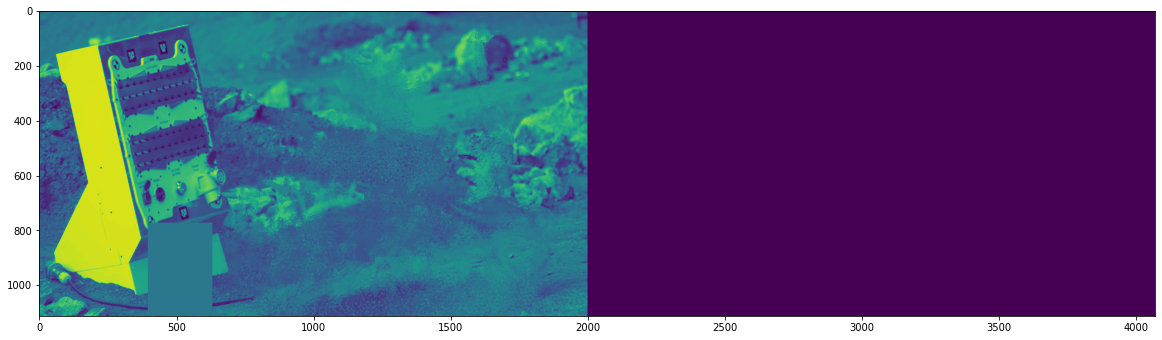

done


In [131]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# video loading
videosrc='../../images/video/task_ext.avi'
trackcap = cv.VideoCapture(videosrc)

# frame extraction
if trackcap.isOpened():
    capret, capframe = trackcap.read()
    extractFuture=1
    if extractFuture:
        current_framenum=trackcap.get(cv.CAP_PROP_POS_FRAMES)
        # extraction of a frame at a future time
        frame_time=5
        if frame_time<=trackcap.get(7)*trackcap.get(5):
            trackcap.set(0, frame_time-1)
            futret,futframe=trackcap.read()
            # resetting video at frame following capframe
            trackcap.set(1,current_framenum)
else: trackcap.release()
    
cap2frame=capframe.copy

# roi as extracted from video (== roi in extended coord)
# roiframe=capframe[roiy:roiy+roih,roix:roix+roiw]
roiframe=capframe
   
# frame shape   
frameH,frameW,_=capframe.shape
# query extraction
qcx,qcy=rcox,(exthr+hr)//2
##conserves same propportion of roi
reduxFactor=3
qh,qw=hr//reduxFactor,wr//reduxFactor
qx,qy=qcx-qw//2,qcy-qh//2

showQuery=0
if showQuery:
    cv.rectangle(capframe,(qx,qy),(qx+qw,qy+qh),(255,255,0),3)
    cv.circle(capframe,(qcx,qcy),min(qh//2,qw//2),(255,255,0),3)
    plt.figure(figsize=(20,10));plt.imshow(capframe);plt.show()
    
# choosen query
qframe=capframe[qy:qy+qh,qx:qx+qw]

# masks, if usefull
extractMask=0
if extractMask:
    ## rectangular
    recMask=cv.rectangle(np.zeros((frameH,frameW),np.uint8),\
                (qx,qy),(qx+qw,qy+qh),255,-1)
    ## circular
    cirMask=cv.circle(np.zeros((frameH,frameW),np.uint8),\
                      (qcx,qcy),min(qh//2,qw//2),(255,255,0),-1)

    recframe=cv.bitwise_and(capframe,capframe,mask=recMask)
    cirframe=cv.bitwise_and(capframe,capframe,mask=cirMask)
    
    showMask=0
    if showMask:
        plt.figure(figsize=(20,10));plt.imshow(recframe);plt.show()
        plt.figure(figsize=(20,10));plt.imshow(cirframe);plt.show()

# random ground region
##test of correct non matching
extractRandom=0
if extractRandom:
    randframe=capframe[500:500+qh,1200:1200+qw]

# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()

convGray=1
if convGray:
    qframe=cv.cvtColor(qframe,cv.COLOR_BGR2GRAY)
    roiframe=cv.cvtColor(roiframe,cv.COLOR_BGR2GRAY)
    if extractRandom:
        randframe=cv.cvtColor(randframe,cv.COLOR_BGR2GRAY)
    if extractFuture:
        futframe=cv.cvtColor(futframe,cv.COLOR_BGR2GRAY)
    if extractMask:
        recframe=cv.cvtColor(recframe,cv.COLOR_BGR2GRAY)
        cirframe=cv.cvtColor(cirframe,cv.COLOR_BGR2GRAY)


# find the keypoints and descriptors with SIFT

kp_q=sift.detect(qframe)
kp_roi = sift.detect(roiframe)
if extractRandom:
    kp_rand=sift.detect(randframe)
if extractFuture:
    kp_fut=sift.detect(futframe)
if extractMask:
    kp_rec=sift.detect(recframe)
    kp_cir=sift.detect(cirframe)

showKp=0
if showKp:
    roiframe2=cv.drawKeypoints(roiframe,kp_roi,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    qframe2=cv.drawKeypoints(qframe,kp_q,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(20,10));plt.imshow(roiframe2);plt.show()
    plt.figure(figsize=(20,10));plt.imshow(qframe2);plt.show()
    if extractMask:
        recframe2=cv.drawKeypoints(recframe,kp_rec,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        cirframe2=cv.drawKeypoints(cirframe,kp_cir,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.figure(figsize=(20,10));plt.imshow(recframe2);plt.show()
        plt.figure(figsize=(20,10));plt.imshow(cirframe2);plt.show()
        
# Describing keypoints for query and train images
kp_roi, desc_roi = sift.compute(roiframe, kp_roi)##train
kp_q, desc_q=sift.compute(qframe,kp_q)
if extractRandom:
    kp_rand,desc_rand=sift.compute(randframe,kp_rand)
if extractFuture:
    kp_fut,desc_fut=sift.compute(futframe,kp_fut)
if extractMask:
    kp_rec, desc_rec = sift.compute(recframe, kp_rec)
    kp_cir, desc_cir=sift.compute(cirframe,kp_cir)
    
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
query_img=qframe
query_kp=kp_q
query_desc=desc_q
target_img=roiframe
target_kp=kp_roi
target_desc=desc_roi
matches = flann.knnMatch(desc_q,desc_roi,k=2)
good_matches = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good_matches)>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    corSrc_pts = np.float32([ query_kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    corDst_pts = np.float32([ target_kp[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    # Using RANSAC to estimate a robust homography. 
    # It returns the homography M and a mask for the discarded points
    matcHom, maskTrash = cv.findHomography(corSrc_pts, corDst_pts, cv.RANSAC, 5.0)
    
    # Mask of discarded point used in visualization
    matchesMask = maskTrash.ravel().tolist()
    
    # Corners of the query image
    hquery,wquery = query_img.shape
    matchPts = np.float32([ [0,0],[0,hquery-1],[wquery-1,hquery-1],[wquery-1,0] ]).reshape(-1,1,2)
    # Projecting the corners into the train image
    destPts = np.int32(cv.perspectiveTransform(matchPts,matcHom))
    # new roi frame
    cv.rectangle(target_img,(destcenx-wquery//2,destceny-hquery//2),\
                (destcenx+wquery//2,destceny+hquery//2),100,-1)
    ##alternatively:
#     roiframe = cv.polylines(target_img,[destPts],True,255,3, cv.LINE_AA)
    # new roi center
    (destcenx,destceny)=destcen=((destPts[0]+destPts[2])//2).reshape(2,1,1)[0],\
                                ((destPts[0]+destPts[2])//2).reshape(2,1,1)[1]
#     cv.circle(target_img,destcen,10,255,-1)
    
    
else:
    print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
    matchesMask = None

plt.figure(figsize=(20,10));plt.imshow(target_img);plt.show();

#Drawing the matches
drawMatches=0
if drawMatches:
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None, # not draw keypoints only matching lines
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2) # not draw keypoints only lines
    img3 = cv.drawMatches(query_img,query_kp,target_img,target_kp,good_matches,None,**draw_params)
    plt.figure(figsize=(20,10));plt.imshow(img3);plt.show();
    
##############
print('done')

In [127]:
# video loading
videosrc='../../images/video/task_ext.avi'
trackcap = cv.VideoCapture(videosrc)
# frame extraction
if trackcap.isOpened():
    capret, capframe = trackcap.read()
    frame_time=5
    if frame_time<=cap.get(7)*cap.get(5):
        cap.set(0, frame_time-1)
        futret,futframe=trackcap.read()
        sap.set(1,1)
else: trackcap.release()



        
        